In [1]:
from pathlib import Path

# 1. Trouve dynamiquement la racine du projet (contenant .gitignore)
cwd = Path.cwd()
PROJECT_ROOT = next(p for p in (cwd, *cwd.parents) if (p / ".gitignore").exists())

print("PROJECT_ROOT =", PROJECT_ROOT)

PROJECT_ROOT = /workspaces/datasciencetest_reco_plante


In [2]:
from pathlib import Path
import pandas as pd
import plotly.express as px
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import DBSCAN
from skimage.feature.texture import graycomatrix as greycomatrix, graycoprops as greycoprops
from collections import Counter
import shutil

In [3]:
# root_dir déjà défini
# root_dir_5_img = PROJECT_ROOT/"dataset"/"plantvillage"/"data"/"plantvillage_5images"/"segmented"
root_dir_5_img = PROJECT_ROOT/"dataset"/"plantvillage"/"data"/"plantvillage dataset"/"segmented"


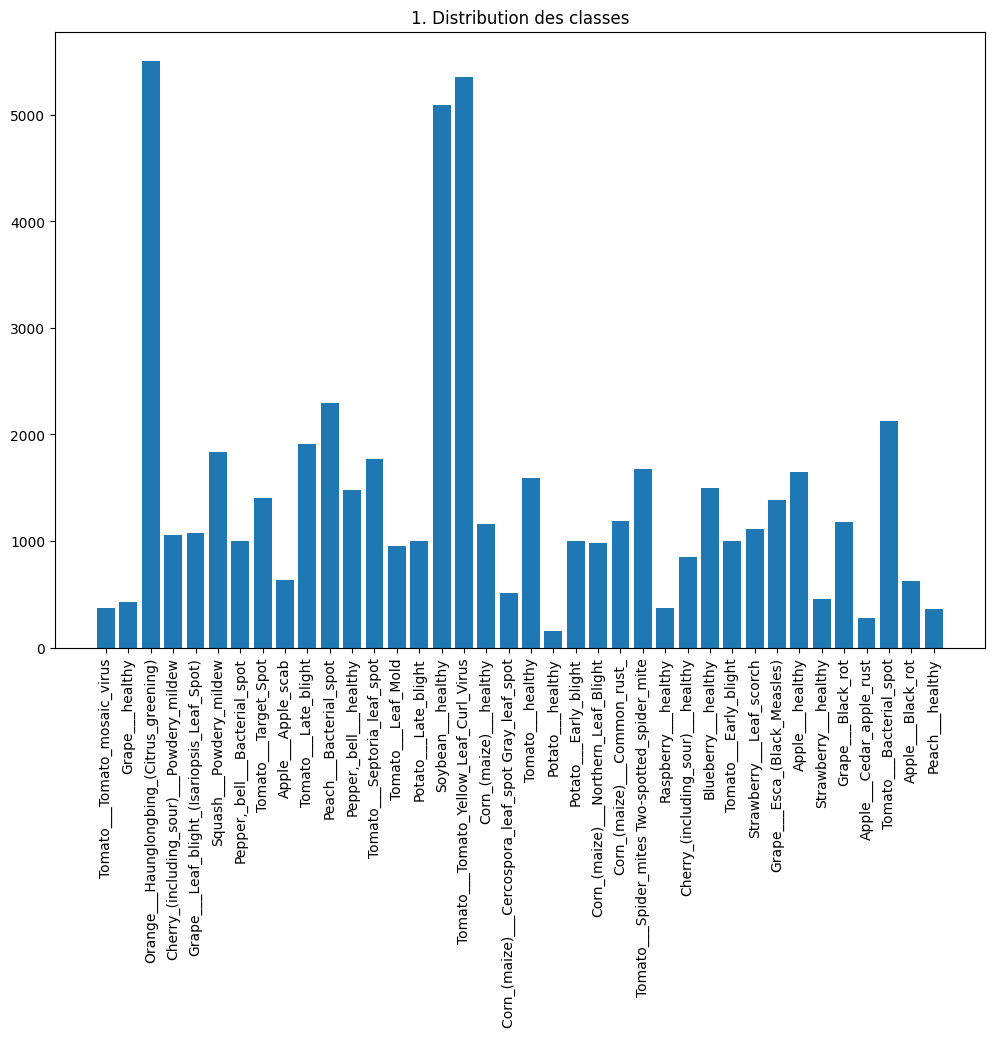

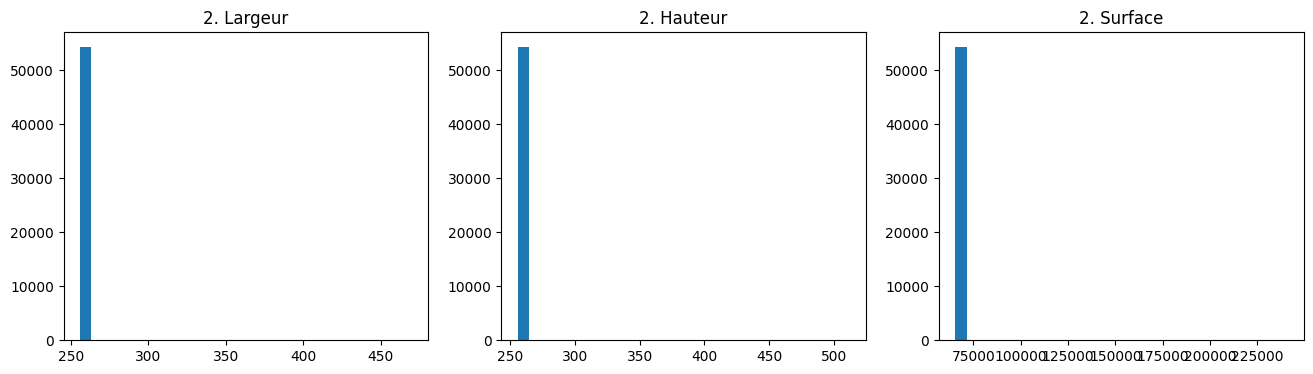

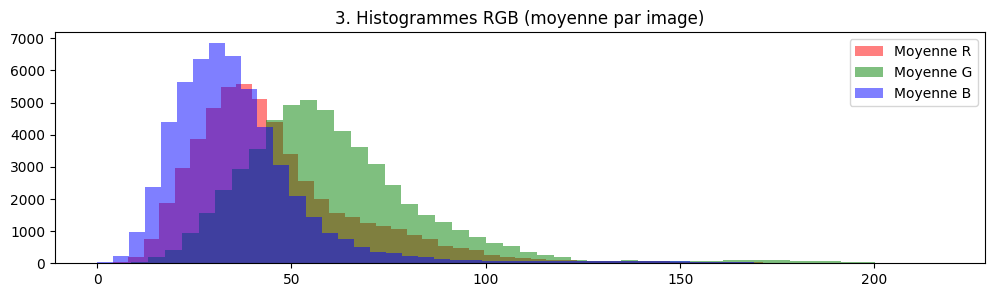

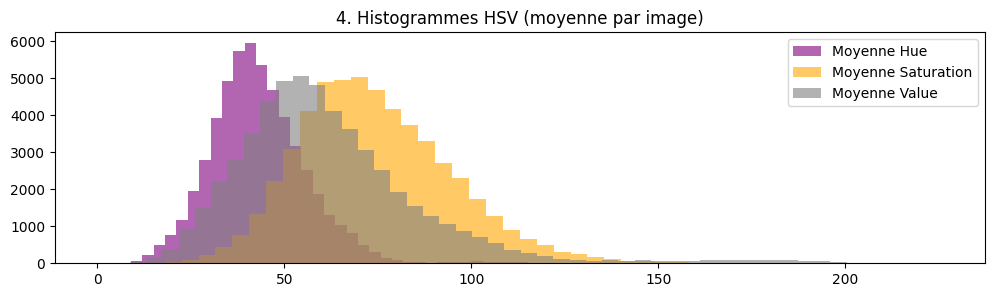

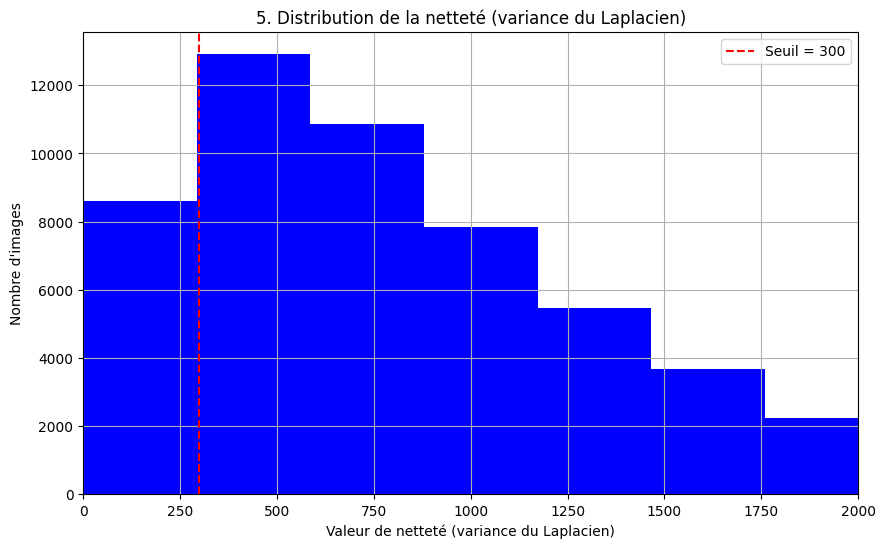

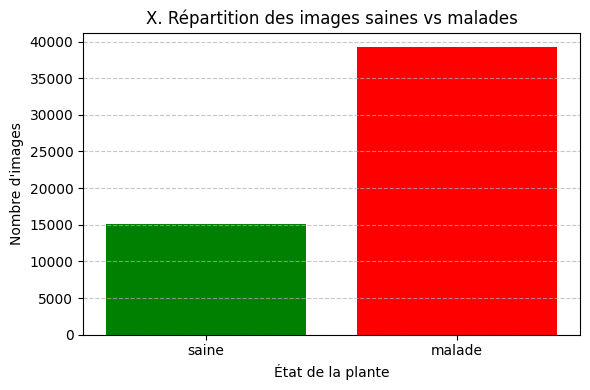

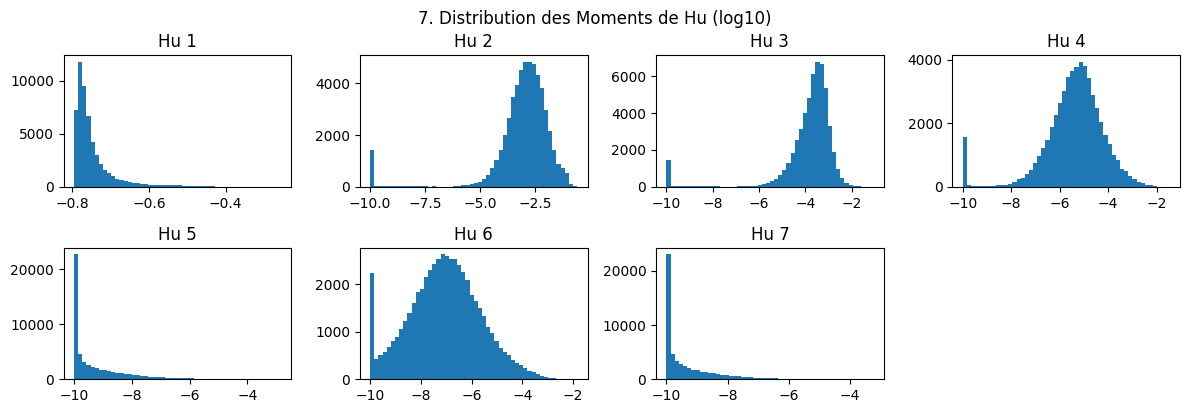

In [5]:
# analyses statistiques du dataset PlantVillage

# Initialisation des listes
class_names = []
image_shapes = []
moy_r, moy_v, moy_b = [], [], []
h_vals, s_vals, v_vals = [], [], []
sharpness_vals = []
moments_hu = []
image_paths = []  # Pour associer netteté/surface à chaque image
compteur = {"saine" : 0 , "malade" : 1} # comteur image saine , malade

# Parcours sur chaque dossier pour toutes les caractéristiques 
for class_dir in os.listdir(root_dir_5_img):
    class_path = os.path.join(root_dir_5_img, class_dir)
    if not os.path.isdir(class_path):
        continue
    # Détermine le tag (saine ou malade)
    santé = "saine" if "healthy" in class_dir.lower() else "malade"

    for file in os.listdir(class_path): #Parcours des fichiers dans le sous-dossier de classe
        if file.lower().endswith(('.png', '.jpg', '.jpeg')): # Si les fichiers images (jpg, png, jpeg)
            compteur[santé] += 1 
            image_path = os.path.join(class_path, file) # Chemin complet de l'image
            try:
                with Image.open(image_path) as img: # Ouverture de l'image avec PIL
                    img = img.convert('RGB')  # Conversion explicite en RGB
                    class_names.append(class_dir) # Stocker le nom de la classe 
                    image_paths.append(image_path) # Stocker le chemin de l'image

                    # 1. Statistique Taille de l'image
                    image_shapes.append(img.size)

                    # 2. Statistiques RGB (moyennes par image) car charge trop importante le PC  plante
                    image_arr = np.array(img) #convertion l’image img en tableau NumPy
                    moy_r.append(image_arr[:, :, 0].mean()) # sélectionne tous les pixels du canal rouge et fait la moyenne
                    moy_v.append(image_arr[:, :, 1].mean()) # sélectionne tous les pixels du canal vert et fait la moyenne
                    moy_b.append(image_arr[:, :, 2].mean()) # sélectionne tous les pixels du canal bleu et fait la moyenne

                    # 3. Statistiques HSV : extrait les moyennes des composantes HSV (Hue (Teinte), S (Saturation), V (luminosité) d'une image
                    hsv = img.convert('HSV') # convertie l'image RGB en HSV
                    hsv_arr = np.array(hsv) # convertion l’image img en tableau NumPy
                    h_vals.append(hsv_arr[:, :, 0].mean()) # Calcule et stocke la moyenne des valeurs de teinte (Hue)
                    s_vals.append(hsv_arr[:, :, 1].mean()) # Calcule et stocke la moyenne des valeurs de saturation (Saturation)
                    v_vals.append(hsv_arr[:, :, 2].mean()) # Calcule et stocke la moyenne des valeurs de luminosité (Luminosité)

                    # 4. Netteté (via le Laplacien de l'image en niveaux de gris)
                    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY) # Convertir en niveaux de gris pour la détection de netteté
                    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var() # Calcul de la variance du Laplacien (mesure de la netteté)
                    sharpness_vals.append(laplacian_var) # Ajouter la valeur de netteté à la liste

                    # 5. Moments de Hu (forme des contours principaux)
                    # Détection des contours dans l’image en niveaux de gris
                    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # détection des bords fermés, contours extérieurs,supprime les points redondants, _ capte une valeur qu’on ignore  
                    if contours: # si contour détecté
                        # On sélectionne le contour qui a la plus grande surface pour ne retenir que la forme principale de l'image
                        largest = max(contours, key=cv2.contourArea) # calcul la surface du contour et retourne le contour qui a la plus grande surface
                        # Calcule les 7 moments invariants de Hu pour le contour sélectionné
                        hu = cv2.HuMoments(cv2.moments(largest)).flatten() # calcule les moments géométriques puis extrait les 7 moments de Hu (invariants à la rotation, translation, mise à l'échelle)
                        moments_hu.append(hu) # Stocke les moments de Hu du contour sélectionné dans une liste

            except Exception as e:
                print(f"Erreur sur {file} : {e}")

# Analyse 1 : Distribution des classes dans le dataset plantvillage
cpt_classe = Counter(class_names)
plt.figure(figsize=(12, 8))
plt.bar(cpt_classe.keys(), cpt_classe.values())
plt.xticks(rotation=90)
plt.title("1. Distribution des classes")
plt.show()

# Analyse 2 : Dimensions des images
widths = [w for (w, h) in image_shapes]
heights = [h for (w, h) in image_shapes]
surfaces = [w * h for (w, h) in image_shapes]

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.hist(widths, bins=30)
plt.title("2. Largeur")
plt.subplot(1, 3, 2)
plt.hist(heights, bins=30)
plt.title("2. Hauteur")
plt.subplot(1, 3, 3)
plt.hist(surfaces, bins=30)
plt.title("2. Surface")
plt.show()

# Analyse 3 : Histogrammes RGB (moyennes)
plt.figure(figsize=(12, 3))
plt.hist(moy_r, bins=50, color='r', alpha=0.5, label='Moyenne R')
plt.hist(moy_v, bins=50, color='g', alpha=0.5, label='Moyenne G')
plt.hist(moy_b, bins=50, color='b', alpha=0.5, label='Moyenne B')
plt.title("3. Histogrammes RGB (moyenne par image)")
plt.legend()
plt.show()

#  Analyse 4 : Histogrammes HSV (moyennes)
plt.figure(figsize=(12, 3))
plt.hist(h_vals, bins=50, color='purple', alpha=0.6, label='Moyenne Hue')
plt.hist(s_vals, bins=50, color='orange', alpha=0.6, label='Moyenne Saturation')
plt.hist(v_vals, bins=50, color='gray', alpha=0.6, label='Moyenne Value')
plt.title("4. Histogrammes HSV (moyenne par image)")
plt.legend()
plt.show()

#  Analyse 5 : Histogramme de netteté
plt.figure(figsize=(10, 6))
plt.hist(sharpness_vals, bins=50, color='blue')
plt.title("5. Distribution de la netteté (variance du Laplacien)")
plt.xlabel("Valeur de netteté (variance du Laplacien)")  # Axe des X
plt.ylabel("Nombre d'images")  # Axe des Y
plt.xlim(0, 2000) # Zoom sur la zone où les valeurs sont les plus fréquentes (ex: < 1000)
seuil_nettete = 300 # Ajout d’un seuil de flou/netteté Valeur choisie pour séparer images floues et nettes
plt.axvline(seuil_nettete, color='red', linestyle='--', label=f"Seuil = {seuil_nettete}")

# Légende pour expliquer le seuil
plt.legend()

plt.grid(True)
plt.show()

# Analyse 6 : Nombre d'images saines vs malades
plt.figure(figsize=(6, 4))
plt.bar(compteur.keys(), compteur.values(), color=["green", "red"])
plt.title("X. Répartition des images saines vs malades")
plt.ylabel("Nombre d'images")
plt.xlabel("État de la plante")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Analyse 7 : Moments de Hu (formes)
if moments_hu:
    hu_array = np.array(moments_hu)
    plt.figure(figsize=(12, 4))
    for i in range(hu_array.shape[1]):
        plt.subplot(2, 4, i+1)
        plt.hist(np.log10(np.abs(hu_array[:, i])+1e-10), bins=50)
        plt.title(f"Hu {i+1}")
    plt.tight_layout()
    plt.suptitle("7. Distribution des Moments de Hu (log10)", y=1.02)
    plt.show()
else:
    print("Aucun moment de Hu calculé. Peut-être aucune forme détectée.")